# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import warnings
warnings.filterwarnings("ignore")

Считывание файла с данными. Он очень большой!

In [2]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 2min 17s


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

# Обработка датасета

Определяю количество лагов доли акции.

In [4]:
num_lags = 4

Чищу данные.

In [5]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# учитываю только основные раскрытия без поправок (пока)
df = df[df['conformed_submission_type'] == "13F-HR"]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
mask = (df['ssh_prn_amt_type'] == 'SH')
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = mask * df.ssh_prn_amt + (1 - mask) * df.market_value / df.close

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
df = df[df['shares'] > 0]
df = df[df['market_value'] > 0]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'close']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 50.6 s


Формуирую датасет для использования в моделях.

In [6]:
%%time

#оставляю только комбинации инвестора и акции с достаточным количеством наблюдений
df['object'] = df.ticker_id.apply(str) + '_' + df.cik.apply(str)
df = df.sort_values(by=['ticker_id', 'cik', 'period'])
df = df[df.groupby(['object']).transform('count')['period'] > num_lags]

Wall time: 16.3 s


In [7]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)

## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [8]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()

Формирую пороговые значения низкой и высокой стоимости.

In [9]:
high_value = 1e9
low_value = 1e7

Рассмотрим некоторые основные описательные статистики.

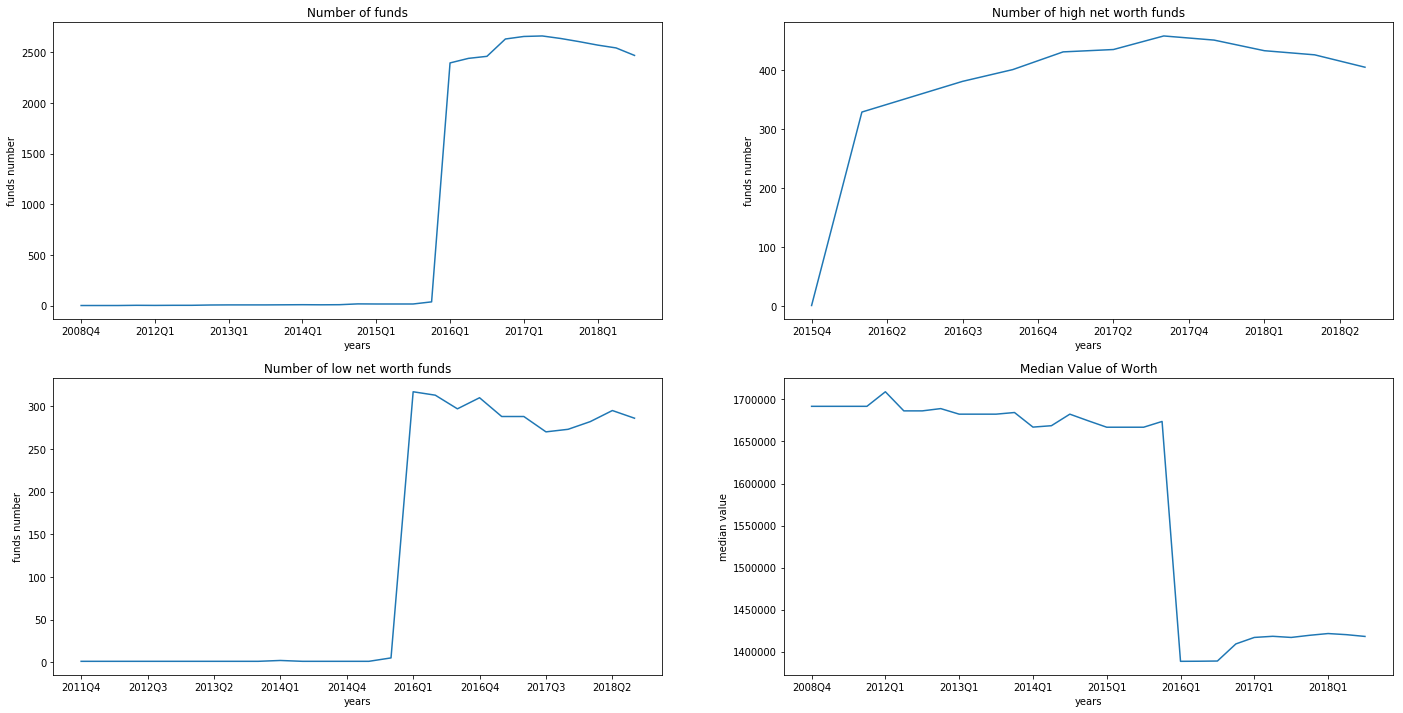

In [10]:
fig, axs = pl.subplots(2, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 0].set_title('Number of funds');
axs[0, 0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value > high_value].groupby('period')['cik'].nunique()
axs[0, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 1].set_title('Number of high net worth funds');
axs[0, 1].set(xlabel='years', ylabel='funds number');
axs[0, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value < low_value].groupby('period')['cik'].nunique()
axs[1, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 0].set_title('Number of low net worth funds');
axs[1, 0].set(xlabel='years', ylabel='funds number');
axs[1, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 1].set_title('Median Value of Worth');
axs[1, 1].set(xlabel='years', ylabel='median value');
axs[1, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

Теперь я посмотрю на распределение ценности фондов.

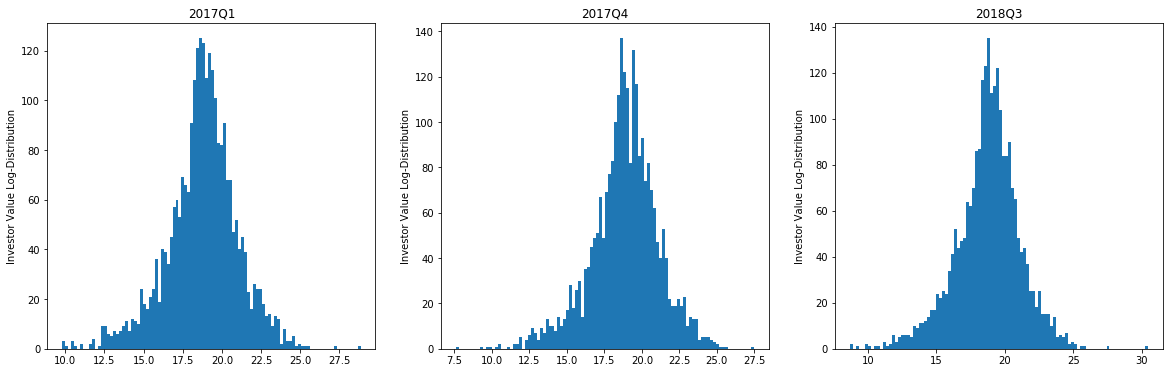

In [11]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [12]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Доля тикера в активах фонда поквартально
final_df['ticket_share'] = final_df.market_value / final_df.market_value_fund
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['low_value'] = final_df.market_value_fund.le(low_value)
final_df['high_value'] = final_df.market_value_fund.ge(high_value)
final_df['med_value'] = ~(final_df['low_value'] + final_df['high_value'])

## Создание лагов регрессий

Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера с начала инвестирования в акцию. Её я и буду предсказывать.

In [13]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_diff'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter \
                - (final_df.period.dt.year * 4 + final_df.period.dt.quarter).shift()

# Создаю лаги для количества акций и доли тикера в активах фонда
for lag in range(1, num_lags + 2):
    final_df['shares_lag' + '_' + str(lag)] = final_df.shares.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
    final_df['ticket_share_lag' + '_' + str(lag)] = final_df.ticket_share.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):
    final_df['net_shares_lag' + '_' + str(lag)] = final_df['shares_lag' + '_' + str(lag)]. \
                                                  div(final_df['shares_lag' + '_' + str(num_lags + 1)], axis=0).sub(1)

final_df['net_shares'] = final_df.shares.div(final_df['shares_lag' + '_' + str(num_lags + 1)], axis = 0).sub(1)

# Избавляюсь от ненужных колонок и наблюдений
final_df.dropna(inplace=True)
final_df.drop(['shares_lag_5', 'ticket_share_lag_5', 'quarter_diff'], axis=1, inplace=True)

Wall time: 18 s


Вот итоговые переменные.

In [14]:
df.head()

,shares,market_value,cik,period,close,ticker_id,object
776888,30681.0,859000.0,5272,2016Q1,28.00,779,779_5272
2488189,29955.0,824062.0,5272,2016Q2,27.51,779,779_5272
4041492,29922.0,862352.0,5272,2016Q3,28.82,779,779_5272
5770014,29473.0,974000.0,5272,2016Q4,33.05,779,779_5272
7388343,24875.0,879000.0,5272,2017Q1,35.35,779,779_5272


In [15]:
final_df.head(10)

,shares,market_value,cik,period,close,ticker_id,object,market_value_fund,ticket_share,log_value_fund,...,ticket_share_lag_2,shares_lag_3,ticket_share_lag_3,shares_lag_4,ticket_share_lag_4,net_shares_lag_1,net_shares_lag_2,net_shares_lag_3,net_shares_lag_4,net_shares
5,30773.0,1134000.0,5272,2017Q2,36.850,779,779_5272,2.746795e+10,0.000041,24.036286,...,0.000038,29922.0,0.000035,29955.0,0.000035,-0.189238,-0.039373,-0.024738,-0.023663,0.002999
6,32699.0,1127000.0,5272,2017Q3,34.475,779,779_5272,2.807241e+10,0.000040,24.058053,...,0.000033,29473.0,0.000038,29922.0,0.000035,0.027308,-0.169588,-0.016091,-0.001102,0.091604
7,32818.0,1204000.0,5272,2017Q4,36.700,779,779_5272,3.011577e+10,0.000040,24.128315,...,0.000041,24875.0,0.000033,29473.0,0.000038,0.092808,0.028441,-0.168672,-0.015006,0.096785
8,26489.0,1033000.0,5272,2018Q1,39.000,779,779_5272,2.838163e+10,0.000036,24.069008,...,0.000040,30773.0,0.000041,24875.0,0.000033,0.113494,0.109456,0.044108,-0.156007,-0.101245
9,31682.0,1053000.0,5272,2018Q2,33.250,779,779_5272,2.824892e+10,0.000037,24.064321,...,0.000040,32699.0,0.000040,30773.0,0.000041,0.064884,0.319317,0.314533,0.237106,0.273648
10,32346.0,1223000.0,5272,2018Q3,37.800,779,779_5272,2.948863e+10,0.000041,24.107271,...,0.000036,32818.0,0.000040,32699.0,0.000040,0.029539,-0.139213,0.066454,0.062587,0.051116
16,12639.0,493000.0,312069,2018Q1,39.000,779,779_312069,2.872419e+09,0.000172,21.778420,...,0.000001,2332.0,0.000040,1922.0,0.000042,0.401279,-0.978038,-0.502772,-0.590192,1.694883
18,14819.0,493000.0,312069,2018Q2,33.250,779,779_312069,2.969951e+09,0.000166,21.811811,...,0.000172,6572.0,0.000105,103.0,0.000001,-0.656518,4.419811,1.818182,-0.955832,5.354631
20,328.0,12000.0,312069,2018Q3,37.800,779,779_312069,3.423550e+09,0.000004,21.953944,...,0.000166,801.0,0.000011,12639.0,0.000172,-0.871424,1.254869,-0.878119,0.923159,-0.950091
27,16288.0,600000.0,315297,2017Q2,36.850,779,779_315297,1.358607e+10,0.000044,23.332311,...,0.000044,16387.0,0.000039,315866.0,0.000734,-0.949315,-0.949007,-0.949007,-0.017087,-0.949315


In [16]:
final_df.columns

Index(['shares', 'market_value', 'cik', 'period', 'close', 'ticker_id',
       'object', 'market_value_fund', 'ticket_share', 'log_value_fund',
       'low_value', 'high_value', 'med_value', 'shares_lag_1',
       'ticket_share_lag_1', 'shares_lag_2', 'ticket_share_lag_2',
       'shares_lag_3', 'ticket_share_lag_3', 'shares_lag_4',
       'ticket_share_lag_4', 'net_shares_lag_1', 'net_shares_lag_2',
       'net_shares_lag_3', 'net_shares_lag_4', 'net_shares'],
      dtype='object')

## Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [17]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticket_share'] - x['ticket_share_lag_1']).sum()).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.head()

,period,cik,turnover
0,2013Q1,1686409,0.107739
1,2013Q1,1731876,0.101049
2,2013Q2,1686409,0.010635
3,2013Q2,1731876,0.078047
4,2013Q3,1655006,0.042335


Теперь HHI.

In [18]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticket_share']).sum()).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2013Q1,1686409,0.316365
1,2013Q1,1731876,0.041415
2,2013Q2,1686409,0.316397
3,2013Q2,1731876,0.040802
4,2013Q3,1655006,0.023250


Теперь посмотрю на их распределение.

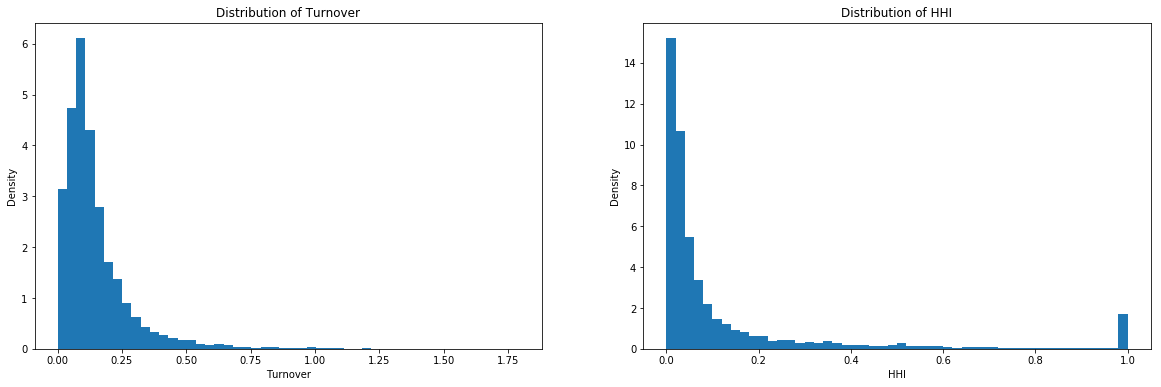

In [19]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].hist(turnover.turnover, density=True, bins=50);
axs[0].set_title('Distribution of Turnover');
axs[0].set(xlabel='Turnover', ylabel='Density');

axs[1].hist(hhi.hhi, density=True, bins=50);
axs[1].set_title('Distribution of HHI');
axs[1].set(xlabel='HHI', ylabel='Density');


Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI.

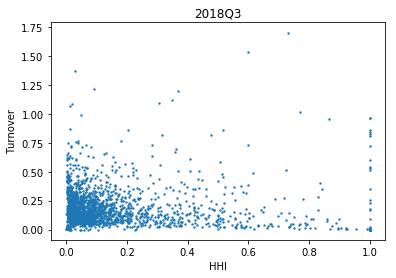

In [20]:
pl.scatter(hhi[hhi.period == final_df.period.max()].hhi, turnover[turnover.period == final_df.period.max()].turnover, s=1.8);
pl.xlabel('HHI');
pl.ylabel('Turnover');
pl.title(final_df.period.max());

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подохрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Добавляю переменные на основе наблюдений.

In [21]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

# Разграничиваю фонды по метрикам через индикаторы
final_df['high_hhi'] = final_df.hhi > .2
final_df['high_turnover'] = final_df.turnover > .5

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

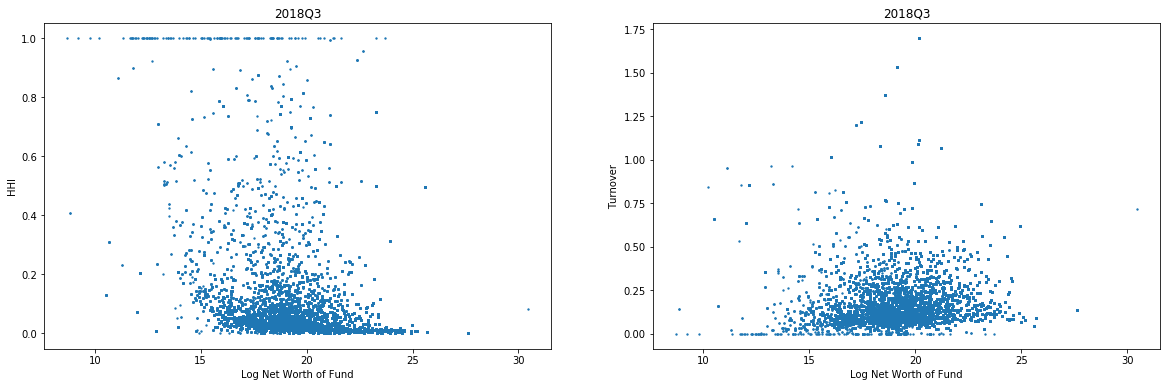

In [80]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].hhi, s=1.8);
axs[0].set_title(final_df.period.max());
axs[0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[1].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].turnover, s=1.8);
axs[1].set_title(final_df.period.max());
axs[1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

Посмотрим на это же совместное распределение, только в разрезе весовой категории фондов.

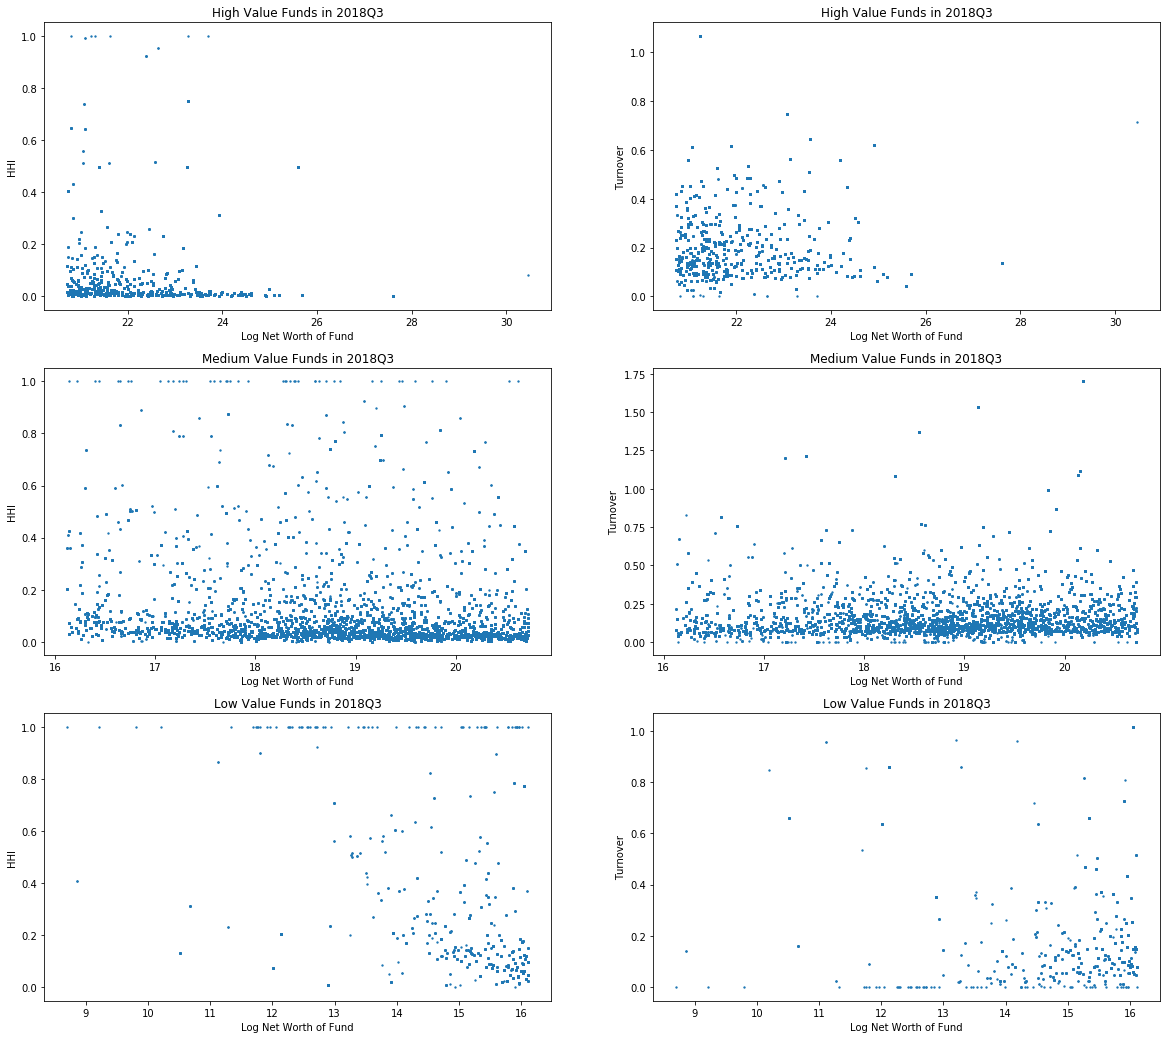

In [79]:
fig, axs = pl.subplots(3, 2, figsize=(20,18));

plot_data_high = final_df[final_df.high_value == True]

axs[0, 0].scatter(plot_data_high[plot_data_high.period == plot_data_high.period.max()].log_value_fund,
           plot_data_high[plot_data_high.period == plot_data_high.period.max()].hhi, s=1.8);
axs[0, 0].set_title('High Value Funds in ' + str(plot_data_high.period.max()));
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[0, 1].scatter(plot_data_high[plot_data_high.period == plot_data_high.period.max()].log_value_fund,
           plot_data_high[plot_data_high.period == plot_data_high.period.max()].turnover, s=1.8);
axs[0, 1].set_title('High Value Funds in ' + str(plot_data_high.period.max()));
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

plot_data_med = final_df[final_df.med_value == True]

axs[1, 0].scatter(plot_data_med[plot_data_med.period == plot_data_med.period.max()].log_value_fund,
           plot_data_med[plot_data_med.period == plot_data_med.period.max()].hhi, s=1.8);
axs[1, 0].set_title('Medium Value Funds in ' + str(plot_data_med.period.max()));
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[1, 1].scatter(plot_data_med[plot_data_med.period == plot_data_med.period.max()].log_value_fund,
           plot_data_med[plot_data_med.period == plot_data_med.period.max()].turnover, s=1.8);
axs[1, 1].set_title('Medium Value Funds in ' + str(plot_data_med.period.max()));
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

plot_data_low = final_df[final_df.low_value == True]

axs[2, 0].scatter(plot_data_low[plot_data_low.period == plot_data_low.period.max()].log_value_fund,
           plot_data_low[plot_data_low.period == plot_data_low.period.max()].hhi, s=1.8);
axs[2, 0].set_title('Low Value Funds in ' + str(plot_data_low.period.max()));
axs[2, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[2, 1].scatter(plot_data_low[plot_data_low.period == plot_data_low.period.max()].log_value_fund,
           plot_data_low[plot_data_low.period == plot_data_low.period.max()].turnover, s=1.8);
axs[2, 1].set_title('Low Value Funds in ' + str(plot_data_low.period.max()));
axs[2, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

Как видно из графиков, в разрезе размера стили инвестирования различаются. Чем больше фонд, чем меньше будет HHI, что говорит о высокой диверсификации их активов, что логично, ведь у них достаточно активов для этого. Про turnover можно сказать так же, но только зависимость уже видна слабее. Тем не менее, стоит факторизировать hhi/turnover и размер фонда.

## Variables Factoring

Теперь я факторизирую (<a href="https://www.stata.com/manuals13/u25.pdf">Variable Factoring</a>, не знаю, как лучше перевести, кросс-перемножу) некоторые непрерывные переменные и весовую категорию фонда по ценности, так как я считаю, что в зависимости от категории будет меняться зависимость от данных регрессоров.

In [23]:
%%time

# Для начала я факторизирую переменные, связанные с долей акций и их количеством, и их лаги
for lag in range(1, num_lags + 1):
    final_df['net_shares_lag' + '_' + str(lag) + '_high'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.high_value, axis=0)
    final_df['net_shares_lag' + '_' + str(lag) + '_med'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.med_value, axis=0)
    final_df['net_shares_lag' + '_' + str(lag) + '_low'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.low_value, axis=0)
    
    final_df['ticket_share_lag' + '_' + str(lag) + '_high'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.high_value, axis=0)
    final_df['ticket_share_lag' + '_' + str(lag) + '_med'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.med_value, axis=0)
    final_df['ticket_share_lag' + '_' + str(lag) + '_low'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.low_value, axis=0)

# Затем я факторизирую turnover и HHI
final_df['turnover' + '_high'] = final_df['turnover'].mul(final_df.high_value, axis=0)
final_df['turnover' + '_med'] = final_df['turnover'].mul(final_df.med_value, axis=0)
final_df['turnover' + '_low'] = final_df['turnover'].mul(final_df.low_value, axis=0)

final_df['hhi' + '_high'] = final_df['turnover'].mul(final_df.high_value, axis=0)
final_df['hhi' + '_med'] = final_df['turnover'].mul(final_df.med_value, axis=0)
final_df['hhi' + '_low'] = final_df['turnover'].mul(final_df.low_value, axis=0)

Wall time: 938 ms


Также я добавлю переменную среднего значения изменения позиции тикера по всем фондам и по фондам одной весовой категории, чтобы учесть, как рынок (инвесторы) и сходие по размеру фонды в целом реагировали на ситуацию.

In [24]:
%%time

# Составляю таблицы средних изменений позиций по тикеру и периоду

mean_net_shares = final_df.groupby(['ticker_id', 'period'])['net_shares_lag_1'].mean().reset_index()
mean_net_shares.rename(columns={'net_shares_lag_1': 'mean_net_shares_lag_1'}, inplace=True)


mean_net_shares_by_value = final_df.groupby(['ticker_id', 'period', 'high_value', 'med_value']) \
                                                        ['net_shares_lag_1'].mean().reset_index()
mean_net_shares_by_value.rename(columns={'net_shares_lag_1': 'mean_net_shares_lag_1_by_value'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_net_shares, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_shares_by_value, on=['ticker_id', 'period', 'high_value', 'med_value'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'high_value', 'med_value'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'high_value', 'med_value', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'high_value', 'med_value'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_net_shares_lag_1'] -= final_df.net_shares_lag_1.div(final_df.tickers_count, axis=0).values
final_df['mean_net_shares_lag_1_by_value'] -= final_df.net_shares_lag_1.div(final_df.tickers_count_by_value, axis=0).values

Wall time: 13.1 s


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>. Начну с простой модели без факторизации.

### Модель 1

In [25]:
import statsmodels.api as sm

In [26]:
y = final_df['net_shares']

X = final_df[['log_value_fund',
        'net_shares_lag_1', 'net_shares_lag_2', 'net_shares_lag_3', 'net_shares_lag_4',
        'turnover', 'hhi', 'hhi_eq_1', 'high_turnover', 'high_hhi', 'mean_net_shares_lag_1']].astype('float64')
X = sm.add_constant(X)

В этой модели я учитываю величину активов фонда, лаги чистых изменений позиций, переменные, связанные с turnover и hhi, и среднее по остальным фондам.

Делаю первую модель. Простой метод наименьших квадратов.

In [27]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                 1.568e+04
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:33:54   Log-Likelihood:            -1.0434e+07
No. Observations:             1342397   AIC:                         2.087e+07
Df Residuals:                 1342385   BIC:                         2.087e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -32.0970      4.943     -6.493      0.000     -41.786     -22.408
log_value_fund            1.3902      0.225      6.177      0.000       0.949       1.831
net_shares_lag_1          0.0417      0.001     76.871      0.000       0.041       0.043
net_shares_lag_2          0.6287      0.002    351.891      0.000       0.625       0.632
net_shares_lag_3          0.0211      0.001     14.640      0.000       0.018       0.024
net_shares_lag_4          0.0305      0.002     20.082      0.000       0.028       0.033
turnover                 38.0226      4.811      7.904      0.000      28.594      47.451
hhi                       8.1278     16.956      0.479      0.632     -25.105      41.361
hhi_eq_1                  4.0078     28.605      0.140      0.889     -52.057      60.073
high_turnover           -15.4644      3.392     -4.559      0.000     -22.113      -8.815
high_hhi                 -2.4548      6.999     -0.351      0.726     -16.173      11.263
mean_net_shares_lag_1    -0.0007      0.005     -0.158      0.874      -0.010       0.008
=================================================================================
Omnibus:                  9090904.400   Durbin-Watson:                      2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21793122544275676.000
Skew:                         683.434   Prob(JB):                            0.00
Kurtosis:                  624203.085   Cond. No.                        5.59e+04
=================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Как видно из результатов регрессии, незначимыми оказались только среднее по фондам и коэфиициенты переменных, связанных с HHI.
Наблюдается положительная зависимость с величиной активов. Значит, чем больше фонд, тем более вероятно, что он будет наращивать свои позиции. Наверно, из-за увеличения доступных средств, которые по диверсификации должны в некой мере быть потрачены на данный тикер.

Также, положительная зависимость от предыдущих изменений. Наблюдается некая состоятельность. Если фонд избавлялся от актива, то он продолжит от него избавляться. Это может быть из-за того, что инвестиционная стратегия, связанная с этим тикером, себя изжила, и фонд выходит из актива. И наоборот, если фонд вкладывал в актив, то он будет продолжать вкладывать. Объяснение аналогичное. 

Кроме того, наблюдается положительная зависимость от turnover. Чем больше оборачиваемость, тем скорее увеличится позиция. При этом, при перехождении границы в степени оборачиваемости (high_turnover) эта уверенность уменьшается. Я понимаю это так. Оборачиваемость означает, что фонд адаптируется к изменениям рынка. С учетом того, что последние годы рынок рос, изменения наверняка положительные, и фонд скорее вложится в актив. Также, фонд наверно будет пытаться защиofnm свои стратегии от провала, поэтому будет подстраховываться другими акциями. Или же будет постоянно менять позиции, так как не хочет, чтобы его стратегии смогли обнаружить. При этом, если фонд слишком усердно меняет позиции, то это скорее говорит, что либо он использует сложные альфы, в которых доля актива постоянно меняется, из-за чего наша уверенность в увеличении позиции уменьшается, либо же у него нет своих собственных планов на тикер, он просто может диверсифицировать активы или повторять рыночный индекс, из-за чего опять же уменьшается уверенность в том, что его вложения в тикер увеличатся.

Аналогичная ситуация с HHI, только этот индекс про диверсификацию, а не про оборачиваемость. Кроме того, присутствует надбавка за владение одной акцией, что наверняка говорит о невероятном инсайде об акции или личной привязанности к компании, поэтому уверенность в увеличении позиции повышается.

Среднее по фондам почти не влияет на зависимую переменную, коэффициент почти близок к нулю. Значит, все фонды разные, и единой стратегии или animal spirit у них не присутствует.

Заметим, что у константы слишком большое значение, в котором тяжело найти прикладной смысл.

В результатах написано, что присутствует сильная мультиколлинеарность, но она нас не волнует, так как не влияет на состоятельность оценок.

Создаю меру настроя инвесторов. То, ради чего затевалась курсовая.

In [28]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)

Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

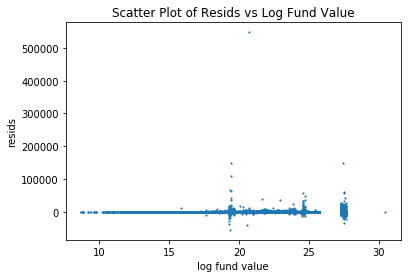

In [29]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

Как можно увидеть, никакой зависимости нет, дисперсия примерно везде одинакова. Она заметно выше в точках границ весовых категорий, но мне кажется, это из-за того, что в этих диапазонах просто больше наблюдений, поэтому разброс чуть повыше.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

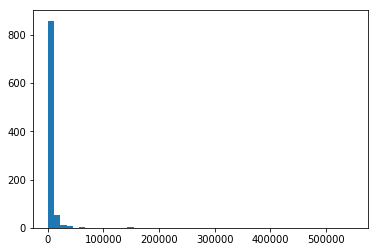

In [30]:
pl.hist(delta_1[delta_1 > 1000], bins=50);

Да, есть много наблюдений, где оценка отличается больше, чем на 1000 процентнов. Вероятно, это из-за того, что в нашей выборке много около-бедных фондов, которые при начале инвестирования в тикер быстро наращивают вложения. При этом, из-за своих возможностей они не могут покупать много акций, из-за чего при постепенном увеличении вложений процентное изменение оказывается невероятно высоким. Это проблема масштаба, как проблема сходимости экономического роста в неразвитых и развитых странах.

Чтобы избавиться от этой проблемы, я нормализую зависимую переменную. Посмотрим, станет ли лучше.

### Модель 2

In [31]:
y = (y - y.mean()) / y.std()

In [32]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                 1.568e+04
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:34:08   Log-Likelihood:            -1.8237e+06
No. Observations:             1342397   AIC:                         3.647e+06
Df Residuals:                 1342385   BIC:                         3.647e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0659      0.008     -8.137      0.000      -0.082      -0.050
log_value_fund            0.0023      0.000      6.177      0.000       0.002       0.003
net_shares_lag_1       6.835e-05   8.89e-07     76.871      0.000    6.66e-05    7.01e-05
net_shares_lag_2          0.0010   2.93e-06    351.891      0.000       0.001       0.001
net_shares_lag_3       3.448e-05   2.36e-06     14.640      0.000    2.99e-05    3.91e-05
net_shares_lag_4       4.997e-05   2.49e-06     20.082      0.000    4.51e-05    5.48e-05
turnover                  0.0623      0.008      7.904      0.000       0.047       0.078
hhi                       0.0133      0.028      0.479      0.632      -0.041       0.068
hhi_eq_1                  0.0066      0.047      0.140      0.889      -0.085       0.098
high_turnover            -0.0253      0.006     -4.559      0.000      -0.036      -0.014
high_hhi                 -0.0040      0.011     -0.351      0.726      -0.026       0.018
mean_net_shares_lag_1  -1.22e-06   7.72e-06     -0.158      0.874   -1.63e-05    1.39e-05
=================================================================================
Omnibus:                  9090904.400   Durbin-Watson:                      2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21793122544275652.000
Skew:                         683.434   Prob(JB):                            0.00
Kurtosis:                  624203.085   Cond. No.                        5.59e+04
=================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Коэффициенты почти не изменились. Тем не менее, коэффициент при константе более осмысленный. Можно сказать, что по умолчанию фонды постепенно выходят из тикеров, но говорить об этом стоит с осторожностью. Наверно, это может происходить, так как стратегии быстрее себя реализуют, чем появляются. Поэтому инвесторы чаще выходят из тикеров, чем входят в них.

In [33]:
# Искомая переменная по второй модели
delta_2 = y - model_2.predict(X)

Если мы посмотрим на экстремальные значения остатков (наблюдений), то заметим, что их стало поменьше, и их экстремальность уменьшилась. Это, несомненно, лучше.

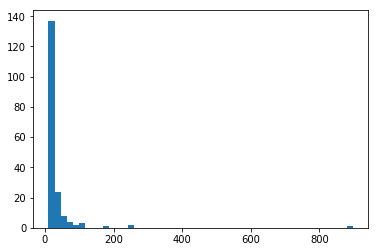

In [34]:
pl.hist(delta_2[delta_2 > 10], bins=50);

На волне успеха попробую нормализовать регрессоры.

### Модель 3

In [35]:
X.iloc[:, 1:-2] = (X.iloc[:, 1:-2] - X.iloc[:, 1:-2].mean()) / X.iloc[:, 1:-2].std()
X.iloc[:, -1] = (X.iloc[:, -1] - X.iloc[:, -1].mean()) / X.iloc[:, -1].std()

In [36]:
model_3 = sm.OLS(y, X).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                 1.568e+04
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:34:11   Log-Likelihood:            -1.8237e+06
No. Observations:             1342397   AIC:                         3.647e+06
Df Residuals:                 1342385   BIC:                         3.647e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.382e-05      0.001      0.077      0.939      -0.002       0.002
log_value_fund            0.0054      0.001      6.177      0.000       0.004       0.007
net_shares_lag_1          0.0637      0.001     76.871      0.000       0.062       0.065
net_shares_lag_2          0.3100      0.001    351.891      0.000       0.308       0.312
net_shares_lag_3          0.0129      0.001     14.640      0.000       0.011       0.015
net_shares_lag_4          0.0171      0.001     20.082      0.000       0.015       0.019
turnover                  0.0095      0.001      7.904      0.000       0.007       0.012
hhi                       0.0007      0.002      0.479      0.632      -0.002       0.004
hhi_eq_1                  0.0001      0.001      0.140      0.889      -0.002       0.002
high_turnover            -0.0054      0.001     -4.559      0.000      -0.008      -0.003
high_hhi                 -0.0040      0.011     -0.351      0.726      -0.026       0.018
mean_net_shares_lag_1    -0.0001      0.001     -0.158      0.874      -0.002       0.001
=================================================================================
Omnibus:                  9090904.400   Durbin-Watson:                      2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21793122544275628.000
Skew:                         683.434   Prob(JB):                            0.00
Kurtosis:                  624203.085   Cond. No.                            18.9
=================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ничего не изменилось, только константа стала почти незначимой. Мне такое не нравится. Не буду так делать. Дополнительной пользы методика не приносит.

Теперь добавлю переменные доли тикера в активах фонда, чтобы посмотреть, как это повлияет на регрессию.

### Модель 4

In [37]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund',
        'net_shares_lag_1', 'net_shares_lag_2', 'net_shares_lag_3', 'net_shares_lag_4',
        'ticket_share_lag_1', 'ticket_share_lag_2', 'ticket_share_lag_3', 'ticket_share_lag_4',
        'turnover', 'hhi', 'hhi_eq_1', 'high_turnover', 'high_hhi', 'mean_net_shares_lag_1']].astype('float64')
X = sm.add_constant(X)

In [38]:
model_4 = sm.OLS(y, X).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                 1.150e+04
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:34:51   Log-Likelihood:            -1.8237e+06
No. Observations:             1342397   AIC:                         3.647e+06
Df Residuals:                 1342381   BIC:                         3.648e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0666      0.008     -8.157      0.000      -0.083      -0.051
log_value_fund            0.0023      0.000      6.219      0.000       0.002       0.003
net_shares_lag_1       6.834e-05   8.89e-07     76.864      0.000    6.66e-05    7.01e-05
net_shares_lag_2          0.0010   2.93e-06    351.890      0.000       0.001       0.001
net_shares_lag_3       3.446e-05   2.36e-06     14.629      0.000    2.98e-05    3.91e-05
net_shares_lag_4       4.997e-05   2.49e-06     20.081      0.000    4.51e-05    5.48e-05
ticket_share_lag_1        0.1781      0.075      2.370      0.018       0.031       0.325
ticket_share_lag_2       -0.2086      0.094     -2.226      0.026      -0.392      -0.025
ticket_share_lag_3        0.0694      0.094      0.736      0.461      -0.115       0.254
ticket_share_lag_4       -0.0168      0.074     -0.227      0.821      -0.162       0.128
turnover                  0.0623      0.008      7.904      0.000       0.047       0.078
hhi                       0.0066      0.029      0.229      0.819      -0.050       0.063
hhi_eq_1                 -0.0127      0.051     -0.250      0.803      -0.113       0.087
high_turnover            -0.0253      0.006     -4.557      0.000      -0.036      -0.014
high_hhi                 -0.0035      0.011     -0.308      0.758      -0.026       0.019
mean_net_shares_lag_1 -1.203e-06   7.72e-06     -0.156      0.876   -1.63e-05    1.39e-05
=================================================================================
Omnibus:                  9090921.351   Durbin-Watson:                      2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21793583407699748.000
Skew:                         683.439   Prob(JB):                            0.00
Kurtosis:                  624209.685   Cond. No.                        1.36e+05
=================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Старые коэффициенты лучше и значимее не стали, а некоторые из новых оказались значительно незначимыми. Значимая зависимость только от первых двух лагов доли. Заметим также разнородный характер зависимости. Первый и третий лаг положительно влияют на зависимую переменную, когда второй и четвертый отрицательно. Это может быть связано с тем, что у инвесторов отчетные периоды каждые полгода, а к этому времени они формируют более диверсифицированное портфолио, чтобы привлечь больше инвесторов, поэтому меняют веса активов в противоположные стороны, чтобы быть более ликвидными. Вследствие такого объяснения у меня пропадает необходимость в 3-м и 4-м лаге для доли, так как дополнительного смысла они не несут.

Заметим, что теперь у коэффициента при среднем по фондам почти нулевое отклонение, что что делает его равносильным константе, из-за чего может возникать муьлтиколлинеарность.

Теперь заменю переменные на их факторизированные аналоги. Должно стать лучше!

### Модель 5

In [46]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund', 'high_value', 'med_value',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'ticket_share_lag_1_high', 'ticket_share_lag_1_med', 'ticket_share_lag_1_low',
        'ticket_share_lag_2_high', 'ticket_share_lag_2_med', 'ticket_share_lag_2_low',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'high_turnover', 'high_hhi',
        'mean_net_shares_lag_1', 'mean_net_shares_lag_1_by_value']].astype('float64')
X = sm.add_constant(X)

In [47]:
model_5 = sm.OLS(y, X).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     9896.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:49:16   Log-Likelihood:            -1.8039e+06
No. Observations:             1342397   AIC:                         3.608e+06
Df Residuals:                 1342374   BIC:                         3.608e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0682      0.016     -4.314      0.000      -0.099      -0.037
log_value_fund                     0.0033      0.001      5.386      0.000       0.002       0.004
high_value                        -0.0275      0.014     -2.027      0.043      -0.054      -0.001
med_value                         -0.0127      0.013     -0.982      0.326      -0.038       0.013
net_shares_lag_1_low           -4341.6626   1.25e+04     -0.349      0.727   -2.87e+04    2.01e+04
net_shares_lag_1_med            8395.2166   2.41e+04      0.349      0.727   -3.88e+04    5.56e+04
net_shares_lag_1_high          -1.468e+08   4.21e+08     -0.349      0.727   -9.72e+08    6.78e+08
net_shares_lag_2_low           -2305.9624   6613.383     -0.349      0.727   -1.53e+04    1.07e+04
net_shares_lag_2_med            6834.6808   1.96e+04      0.349      0.727   -3.16e+04    4.53e+04
net_shares_lag_2_high          -2.475e+04    7.1e+04     -0.349      0.727   -1.64e+05    1.14e+05
net_shares_lag_3_low              -0.0001      0.000     -0.313      0.754      -0.001       0.001
net_shares_lag_3_med           -7.117e-06   2.89e-06     -2.463      0.014   -1.28e-05   -1.45e-06
net_shares_lag_3_high              0.0002    4.4e-06     44.840      0.000       0.000       0.000
net_shares_lag_4_low               0.0155      0.001     16.046      0.000       0.014       0.017
net_shares_lag_4_med            1.618e-05    2.7e-06      5.994      0.000    1.09e-05    2.15e-05
net_shares_lag_4_high              0.0002   5.92e-06     29.596      0.000       0.000       0.000
ticket_share_lag_1_high         1.468e+08   4.21e+08      0.349      0.727   -6.78e+08    9.72e+08
ticket_share_lag_1_med         -8395.2166   2.41e+04     -0.349      0.727   -5.56e+04    3.88e+04
ticket_share_lag_1_low          4341.6610   1.25e+04      0.349      0.727   -2.01e+04    2.87e+04
ticket_share_lag_2_high         2.475e+04    7.1e+04      0.349      0.727   -1.14e+05    1.64e+05
ticket_share_lag_2_med         -6834.6802   1.96e+04     -0.349      0.727   -4.53e+04    3.16e+04
ticket_share_lag_2_low          2305.9626   6613.383      0.349      0.727   -1.07e+04    1.53e+04
turnover_high                   -199.6779    572.747     -0.349      0.727   -1322.243     922.887
turnover_med                    -219.9715    630.976     -0.349      0.727   -1456.662    1016.719
turnover_low                     -97.2523    278.949     -0.349      0.727    -643.983     449.478
hhi_high                         199.7346    572.747      0.349      0.727    -922.831    1322.300
hhi_med                          220.0472    630.976      0.349      0.727   -1016.643    1456.738
hhi_low                           97.2763    278.949      0.349      0.727    -449.454     644.007
high_turnover 

В результате этой регрессии коэффициенты стали приобретать какие-то фантастические значения: от почти нуля до почти бесконечности. Это не имеет смысла. Я попробую убрать переменные, связанные с долей акции, так как в этой группе все коэффициенты бессмысленно огромные и незначимые.

Опять замечу, что у коэффициента при среднем по схожим фондам такие же проблемы с похожестью на константу.

### Модель 6

In [48]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund', 'high_value', 'med_value',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'high_turnover', 'high_hhi',
        'mean_net_shares_lag_1', 'mean_net_shares_lag_1_by_value']].astype('float64')
X = sm.add_constant(X)

In [49]:
model_6 = sm.OLS(y, X).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     9896.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:50:22   Log-Likelihood:            -1.8039e+06
No. Observations:             1342397   AIC:                         3.608e+06
Df Residuals:                 1342374   BIC:                         3.608e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0682      0.016     -4.314      0.000      -0.099      -0.037
log_value_fund                     0.0033      0.001      5.380      0.000       0.002       0.004
high_value                        -0.0274      0.014     -2.020      0.043      -0.054      -0.001
med_value                         -0.0126      0.013     -0.974      0.330      -0.038       0.013
net_shares_lag_1_low              -0.0017      0.002     -1.012      0.312      -0.005       0.002
net_shares_lag_1_med            2.818e-05   9.07e-07     31.062      0.000    2.64e-05       3e-05
net_shares_lag_1_high              0.0006   3.44e-06    164.295      0.000       0.001       0.001
net_shares_lag_2_low               0.0002      0.001      0.148      0.882      -0.002       0.002
net_shares_lag_2_med               0.0006   6.09e-06     97.707      0.000       0.001       0.001
net_shares_lag_2_high              0.0008   3.92e-06    201.855      0.000       0.001       0.001
net_shares_lag_3_low              -0.0002      0.000     -0.454      0.650      -0.001       0.001
net_shares_lag_3_med           -7.115e-06   2.89e-06     -2.462      0.014   -1.28e-05   -1.45e-06
net_shares_lag_3_high              0.0002   4.39e-06     44.841      0.000       0.000       0.000
net_shares_lag_4_low               0.0155      0.001     16.043      0.000       0.014       0.017
net_shares_lag_4_med            1.618e-05    2.7e-06      5.994      0.000    1.09e-05    2.15e-05
net_shares_lag_4_high              0.0002   5.92e-06     29.597      0.000       0.000       0.000
turnover_high                      0.0284      0.005      6.228      0.000       0.019       0.037
turnover_med                       0.0379      0.005      7.316      0.000       0.028       0.048
turnover_low                       0.0120      0.023      0.519      0.604      -0.033       0.057
hhi_high                           0.0284      0.005      6.228      0.000       0.019       0.037
hhi_med                            0.0379      0.005      7.316      0.000       0.028       0.048
hhi_low                            0.0120      0.023      0.519      0.604      -0.033       0.057
high_turnover                     -0.0188      0.006     -3.393      0.001      -0.030      -0.008
high_hhi                          -0.0030      0.006     -0.464      0.643      -0.016       0.010
mean_net_shares_lag_1          -3.237e-06   1.79e-05     -0.181      0.856   -3.83e-05    3.18e-05
mean_net_shares_lag_1_by_value  2.482e-06   1.66e-05      0.150      0.881      -3e-05     3.5e-05
=================================================================================
Omnibus:                  9190766.457   Durbin-Watson:                      2.024
Prob(Omnibus):                  0.000   Jarque-B

Как же преобразилась ситуация. Коэффициенты опять стали более осмысленными и менее разнородными. <b>Как же приятно принимать правильные решения!</b>

Если смотреть глубже, то можно заметить, что незначимы все коэффициенты для малой весовой категории. Вероятно, на низкой ценности стратегии инвестирования своеобразны и независят от предыдущих тенденций.

Заметим, что для маленьких фондов предыдущие изменения отрицательно влияют на предполагаемое, тогда когда для других размеров изменение влияет положительно. Возможно, из-за того, что средств у маленьких фондов недостаточно, чтобы вкладываться во все свои проекты, им постоянно приходится изымать часть средств из активных стратегий.

Также отмечу, что вне зависимости от размера HHI и Turnover положительно влияют на изменение позиции. Ещё можно отметить, что средние и большие фонды получают штраф за свой размер (отрицательный коэффициент перед индикаторами размера). Вероятно, это связано с тем, что большие фонды постоянно диверсифицируют свое портфолио, чтобы поддерживать ликвидность портфеля.

Кроме того, изменение не зависит от среднего изменения по фондам схожей весовой категории. <i>Размер не имеет значения?</i>
Ещё интересно, что индикатор средней категории тоже не значим. Возможно, так как большинство фондов, как замечалось ранее, ближе к бедным, у которых необъяснимые стратегии инвестирования.

Значимость факторизации проявляется в том, что масштабы всех коэффициентов в разы (!!!) уменьшились.

# Макро-параметры

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [50]:
import pandas_datareader as wb

In [51]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [52]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [53]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [54]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 17 s


Теперь построим модель с макроиндикаторами!

### Модель 7

In [56]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund', 'high_value', 'med_value',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'high_turnover', 'high_hhi',
        'mean_net_shares_lag_1', 'mean_net_shares_lag_1_by_value',
         'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [57]:
model_8 = sm.OLS(y, X).fit()
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     8065.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:01:17   Log-Likelihood:            -1.8039e+06
No. Observations:             1342397   AIC:                         3.608e+06
Df Residuals:                 1342369   BIC:                         3.608e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.1025      0.019     -5.437      0.000      -0.139      -0.066
log_value_fund                     0.0032      0.001      5.258      0.000       0.002       0.004
high_value                        -0.0256      0.014     -1.887      0.059      -0.052       0.001
med_value                         -0.0114      0.013     -0.881      0.378      -0.037       0.014
net_shares_lag_1_low              -0.0017      0.002     -1.018      0.309      -0.005       0.002
net_shares_lag_1_med            2.817e-05   9.07e-07     31.054      0.000    2.64e-05    2.99e-05
net_shares_lag_1_high              0.0006   3.44e-06    164.294      0.000       0.001       0.001
net_shares_lag_2_low               0.0002      0.001      0.152      0.879      -0.002       0.002
net_shares_lag_2_med               0.0006   6.09e-06     97.710      0.000       0.001       0.001
net_shares_lag_2_high              0.0008   3.92e-06    201.859      0.000       0.001       0.001
net_shares_lag_3_low              -0.0002      0.000     -0.476      0.634      -0.001       0.001
net_shares_lag_3_med           -7.106e-06   2.89e-06     -2.459      0.014   -1.28e-05   -1.44e-06
net_shares_lag_3_high              0.0002   4.39e-06     44.844      0.000       0.000       0.000
net_shares_lag_4_low               0.0155      0.001     16.053      0.000       0.014       0.017
net_shares_lag_4_med            1.621e-05    2.7e-06      6.007      0.000    1.09e-05    2.15e-05
net_shares_lag_4_high              0.0002   5.92e-06     29.606      0.000       0.000       0.000
turnover_high                      0.0258      0.005      5.602      0.000       0.017       0.035
turnover_med                       0.0356      0.005      6.847      0.000       0.025       0.046
turnover_low                       0.0112      0.023      0.482      0.630      -0.034       0.057
hhi_high                           0.0258      0.005      5.602      0.000       0.017       0.035
hhi_med                            0.0356      0.005      6.847      0.000       0.025       0.046
hhi_low                            0.0112      0.023      0.482      0.630      -0.034       0.057
high_turnover                     -0.0172      0.006     -3.100      0.002      -0.028      -0.006
high_hhi                          -0.0033      0.006     -0.513      0.608      -0.016       0.009
mean_net_shares_lag_1           -3.79e-06   1.79e-05     -0.212      0.832   -3.88e-05    3.12e-05
mean_net_shares_lag_1_by_value  2.272e-06   1.66e-05      0.137      0.891   -3.02e-05    3.48e-05
DGS10                             -0.4777      1.089     -0.439      0.661      -2.613       1.658
DFF                                7.5321      1.717      4.387      0.000       4.167      10.898
UNRATE        

Все индикаторы, кроме ставки по облигациям, оказались значимыми.

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Давайте для интереса посмотрим, какие переменные отвечают за мультиколлинеарность.

In [58]:
%%time

from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = model_8.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vif_series = pd.Series(index=X.columns, data=vif)
vif_series[vif_series >= 10].index.values

Wall time: 3min 9s


array(['const', 'high_value', 'med_value', 'turnover_high',
       'turnover_med', 'turnover_low', 'hhi_high', 'hhi_med', 'hhi_low',
       'CPIAUCSL'], dtype=object)

Мы видим тут константу (она коррелирует со средним по фондам и средним по схожим фондам), индикаторы размера, так как они сильно коррелируют с другими факторизованными переменными, переменные, связанные с turnover и HHI, так как они связаны сильно с лагами и доходом соотвественно, а также похожи на константу в силу маленькой дисперсии, и инфляцию, так как она связана со всеми макро показателями.

## Мы не можем жить без ~~космоса~~ факторизации

Предположу, что фонд будет по-разному реагировать на изменение макроэкономического положения в зависимости от своего размера. Поэтому факторизую индикаторы и построю на новых переменных регрессию.

In [59]:
for macro_factor in ['DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']:
    final_df[macro_factor + '_high'] = final_df[macro_factor].mul(final_df.high_value, axis=0)
    final_df[macro_factor + '_med'] = final_df[macro_factor].mul(final_df.med_value, axis=0)
    final_df[macro_factor + '_low'] = final_df[macro_factor].mul(final_df.low_value, axis=0)

### Модель 8

In [60]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund', 'high_value', 'med_value',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'high_turnover', 'high_hhi',
        'mean_net_shares_lag_1', 'mean_net_shares_lag_1_by_value',
        'DGS10_high', 'DGS10_med', 'DGS10_low', 'DFF_high', 'DFF_med', 'DFF_low', 'UNRATE_high',
        'UNRATE_med', 'UNRATE_low', 'CPIAUCSL_high', 'CPIAUCSL_med',
        'CPIAUCSL_low', 'GDP_high', 'GDP_med', 'GDP_low']].astype('float64')
X = sm.add_constant(X)

In [61]:
model_9 = sm.OLS(y, X).fit()
model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     5886.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:18:18   Log-Likelihood:            -1.8039e+06
No. Observations:             1342397   AIC:                         3.608e+06
Df Residuals:                 1342359   BIC:                         3.608e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0451      0.135     -0.334      0.738      -0.310       0.219
log_value_fund                     0.0031      0.001      5.123      0.000       0.002       0.004
high_value                        -0.0909      0.135     -0.671      0.502      -0.356       0.174
med_value                         -0.0603      0.136     -0.444      0.657      -0.326       0.206
net_shares_lag_1_low              -0.0016      0.002     -1.008      0.314      -0.005       0.002
net_shares_lag_1_med            2.818e-05   9.07e-07     31.063      0.000    2.64e-05       3e-05
net_shares_lag_1_high              0.0006   3.44e-06    164.294      0.000       0.001       0.001
net_shares_lag_2_low               0.0002      0.001      0.145      0.885      -0.002       0.002
net_shares_lag_2_med               0.0006   6.09e-06     97.708      0.000       0.001       0.001
net_shares_lag_2_high              0.0008   3.92e-06    201.858      0.000       0.001       0.001
net_shares_lag_3_low              -0.0002      0.000     -0.454      0.650      -0.001       0.001
net_shares_lag_3_med           -7.114e-06   2.89e-06     -2.462      0.014   -1.28e-05   -1.45e-06
net_shares_lag_3_high              0.0002   4.39e-06     44.848      0.000       0.000       0.000
net_shares_lag_4_low               0.0154      0.001     15.962      0.000       0.014       0.017
net_shares_lag_4_med            1.618e-05    2.7e-06      5.997      0.000    1.09e-05    2.15e-05
net_shares_lag_4_high              0.0002   5.92e-06     29.607      0.000       0.000       0.000
turnover_high                      0.0241      0.005      5.210      0.000       0.015       0.033
turnover_med                       0.0368      0.005      7.051      0.000       0.027       0.047
turnover_low                       0.0113      0.024      0.481      0.631      -0.035       0.057
hhi_high                           0.0241      0.005      5.210      0.000       0.015       0.033
hhi_med                            0.0368      0.005      7.051      0.000       0.027       0.047
hhi_low                            0.0113      0.024      0.481      0.631      -0.035       0.057
high_turnover                     -0.0163      0.006     -2.920      0.004      -0.027      -0.005
high_hhi                          -0.0033      0.006     -0.507      0.612      -0.016       0.009
mean_net_shares_lag_1          -4.711e-06   1.79e-05     -0.264      0.792   -3.97e-05    3.03e-05
mean_net_shares_lag_1_by_value  3.427e-06   1.66e-05      0.207      0.836   -2.91e-05    3.59e-05
DGS10_high                        -0.3449      1.363     -0.253      0.800      -3.017       2.327
DGS10_med                         -1.6439      1.843     -0.892      0.372      -5.257       1.969
DGS10_low     

Из модели можно заметить, что индикаторы значимо влияют только на большие фонды и иногда на средние (как ключевая ставка, которая оказалась более универсальной).

Вероятно, маленькие фонды не думают о глобальном. Кроме того, направленность эффекта от макроиндикаторов у них противоположная в отличие от средних и больших фондов. В любом случае, это, наверно, объясняется спецификой больших фондов, которая обсуждалась в этой работе и требует ещё более тщательного анализа.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

## Баллада о ставке

Мне показалось странным, что ставка по облигациям незначима для предсказания чистого изменения. Возможно, проблема в том, что нам надо учитывать не её изменение, а её абсолютное значение. Сейчас я проверю данное предположение.

In [62]:
# удаляю столбец с данными об изменении ставки
final_df.drop('DGS10', axis=1, inplace=True)

# скачиваю и преобразую данные по ставке к нужному виду
treas_10yr = wb.DataReader('DGS10', 'fred', start=2012).resample('Q-DEC').mean() / 100
treas_10yr.reset_index(inplace=True)
treas_10yr.DATE = treas_10yr.DATE.dt.to_period('Q')

# Свожу данные с датасетом
final_df = final_df.merge(treas_10yr, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Построим регрессию на новых данных.

### Модель 9

In [68]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund', 'high_value', 'med_value',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'high_turnover', 'high_hhi',
        'mean_net_shares_lag_1', 'mean_net_shares_lag_1_by_value',
         'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [69]:
model_11 = sm.OLS(y, X).fit()
model_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     8070.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:24:21   Log-Likelihood:            -1.8038e+06
No. Observations:             1342397   AIC:                         3.608e+06
Df Residuals:                 1342369   BIC:                         3.608e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0634      0.018     -3.595      0.000      -0.098      -0.029
log_value_fund                     0.0030      0.001      4.971      0.000       0.002       0.004
high_value                        -0.0241      0.014     -1.776      0.076      -0.051       0.003
med_value                         -0.0109      0.013     -0.842      0.400      -0.036       0.014
net_shares_lag_1_low              -0.0017      0.002     -1.017      0.309      -0.005       0.002
net_shares_lag_1_med            2.818e-05   9.07e-07     31.068      0.000    2.64e-05       3e-05
net_shares_lag_1_high              0.0006   3.44e-06    164.313      0.000       0.001       0.001
net_shares_lag_2_low               0.0002      0.001      0.168      0.867      -0.002       0.002
net_shares_lag_2_med               0.0006   6.09e-06     97.702      0.000       0.001       0.001
net_shares_lag_2_high              0.0008   3.92e-06    201.866      0.000       0.001       0.001
net_shares_lag_3_low              -0.0002      0.000     -0.528      0.598      -0.001       0.001
net_shares_lag_3_med           -7.149e-06   2.89e-06     -2.474      0.013   -1.28e-05   -1.49e-06
net_shares_lag_3_high              0.0002   4.39e-06     44.858      0.000       0.000       0.000
net_shares_lag_4_low               0.0155      0.001     16.037      0.000       0.014       0.017
net_shares_lag_4_med            1.618e-05    2.7e-06      5.994      0.000    1.09e-05    2.15e-05
net_shares_lag_4_high              0.0002   5.92e-06     29.597      0.000       0.000       0.000
turnover_high                      0.0253      0.005      5.519      0.000       0.016       0.034
turnover_med                       0.0375      0.005      7.216      0.000       0.027       0.048
turnover_low                       0.0123      0.023      0.531      0.595      -0.033       0.058
hhi_high                           0.0253      0.005      5.519      0.000       0.016       0.034
hhi_med                            0.0375      0.005      7.216      0.000       0.027       0.048
hhi_low                            0.0123      0.023      0.531      0.595      -0.033       0.058
high_turnover                     -0.0166      0.006     -2.991      0.003      -0.027      -0.006
high_hhi                          -0.0028      0.006     -0.436      0.662      -0.016       0.010
mean_net_shares_lag_1          -3.219e-06   1.79e-05     -0.180      0.857   -3.82e-05    3.18e-05
mean_net_shares_lag_1_by_value  2.708e-06   1.66e-05      0.163      0.870   -2.98e-05    3.52e-05
DGS10                             -5.3778      0.526    -10.220      0.000      -6.409      -4.346
DFF                               28.4986      2.476     11.510      0.000      23.646      33.351
UNRATE        

Теперь мы видим, что ставка значима. Наконец-то в модели появился здравый смысл. Её знак можно объяснить тем, что при увеличении ставки (безрисковой доходности) привлекательность более рискованных финансовых активов падает, и безрисковые активы начинают их вытеснять.

Теперь посмотрим, как факторизация ставки повлияет на её влияние на модель.

Сначала факторизируем переменную.

In [70]:
for macro_factor in ['DGS10']:
    final_df[macro_factor + '_high'] = final_df[macro_factor].mul(final_df.high_value, axis=0)
    final_df[macro_factor + '_med'] = final_df[macro_factor].mul(final_df.med_value, axis=0)
    final_df[macro_factor + '_low'] = final_df[macro_factor].mul(final_df.low_value, axis=0)

Теперь построим регрессию.

### Модель 10

In [71]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund', 'high_value', 'med_value',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'high_turnover', 'high_hhi',
        'mean_net_shares_lag_1', 'mean_net_shares_lag_1_by_value',
        'DGS10_high', 'DGS10_med', 'DGS10_low', 'DFF_high', 'DFF_med', 'DFF_low', 'UNRATE_high',
        'UNRATE_med', 'UNRATE_low', 'CPIAUCSL_high', 'CPIAUCSL_med',
        'CPIAUCSL_low', 'GDP_high', 'GDP_med', 'GDP_low']].astype('float64')
X = sm.add_constant(X)

In [72]:
model_12 = sm.OLS(y, X).fit()
model_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     5893.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:25:14   Log-Likelihood:            -1.8037e+06
No. Observations:             1342397   AIC:                         3.608e+06
Df Residuals:                 1342359   BIC:                         3.608e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0572      0.098     -0.584      0.559      -0.249       0.135
log_value_fund                     0.0027      0.001      4.405      0.000       0.001       0.004
high_value                        -0.0029      0.098     -0.029      0.977      -0.195       0.190
med_value                         -0.0363      0.098     -0.369      0.712      -0.229       0.156
net_shares_lag_1_low              -0.0017      0.002     -1.013      0.311      -0.005       0.002
net_shares_lag_1_med            2.817e-05   9.07e-07     31.064      0.000    2.64e-05       3e-05
net_shares_lag_1_high              0.0006   3.44e-06    164.337      0.000       0.001       0.001
net_shares_lag_2_low               0.0002      0.001      0.147      0.883      -0.002       0.002
net_shares_lag_2_med               0.0006   6.09e-06     97.717      0.000       0.001       0.001
net_shares_lag_2_high              0.0008   3.92e-06    201.876      0.000       0.001       0.001
net_shares_lag_3_low              -0.0002      0.000     -0.446      0.655      -0.001       0.001
net_shares_lag_3_med           -7.111e-06   2.89e-06     -2.461      0.014   -1.28e-05   -1.45e-06
net_shares_lag_3_high              0.0002   4.39e-06     44.880      0.000       0.000       0.000
net_shares_lag_4_low               0.0155      0.001     16.039      0.000       0.014       0.017
net_shares_lag_4_med             1.62e-05    2.7e-06      6.002      0.000    1.09e-05    2.15e-05
net_shares_lag_4_high              0.0002   5.92e-06     29.592      0.000       0.000       0.000
turnover_high                      0.0217      0.005      4.717      0.000       0.013       0.031
turnover_med                       0.0346      0.005      6.619      0.000       0.024       0.045
turnover_low                       0.0085      0.024      0.361      0.718      -0.038       0.055
hhi_high                           0.0217      0.005      4.717      0.000       0.013       0.031
hhi_med                            0.0346      0.005      6.619      0.000       0.024       0.045
hhi_low                            0.0085      0.024      0.361      0.718      -0.038       0.055
high_turnover                     -0.0128      0.006     -2.293      0.022      -0.024      -0.002
high_hhi                          -0.0034      0.006     -0.526      0.599      -0.016       0.009
mean_net_shares_lag_1          -2.065e-06   1.79e-05     -0.116      0.908   -3.71e-05     3.3e-05
mean_net_shares_lag_1_by_value  1.525e-06   1.66e-05      0.092      0.927    -3.1e-05     3.4e-05
DGS10_high                       -10.7539      0.706    -15.231      0.000     -12.138      -9.370
DGS10_med                          1.1516      0.800      1.440      0.150      -0.416       2.720
DGS10_low     

Как и для других макроиндикаторов, ставка оказалась значимой для больших фондов и не очень значимой для остальных.

Заметим также, что в зависимости от размера направление эффекта другое, чем было в прошлой модели. В прошлой модели у маленьких фондов направление отличалось от остальных, а здесь большие фонды встали особняком от других. Это соответствует всем макропоказателям. Получается, в зависимости от того, берем ли мы разницу ставки или её абсолютное значение, мы получаем две разные модели с разным характером влияния макроиндикаторов. Хотелось бы это объяснить, но хочется для этого лучше понимать специфику инвестирования фондов в разных весовых категориях.

# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [81]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

# Планируемая работа

1. Усовершенствовать чистку исходных данных, так как сейчас она примитивна.

    Как минимум, стоит учесть поправки к исходным отчетам, но пока непонятен их характер. Там присутствуют поправки только по активам, которых не было в исходном отчете, или же там есть поправки по активам, которые уже были упомянуты. Можно создать индикатор того, что актив был в поправках, кстати.<br><br>
   
2. Выгрузить названия фондов из EDGAR и через Thomas Reuters сопоставить им их стили инвестирования, через что можно было бы определить схожие фонды. Потом можно было бы вычислить, например, среднее изменение актива по схожим фондам или составить кросс-произведение с другими индикаторами.<br><br>

3. Аналогичная ситуация с акциями. Для них можно получить их индустрию. В сущности, можно тоже вычислить схожие фонды по их выбору индустрий. Также можно добавить фичи принадлежности акции индустрии, указать изменение позиции фонда по индустрии и долю индустрии в фонде. Кроме того, можно посчитать HHI и Turnover не в разрезе акций, а в разрезе индустрий. Можно сделать много новых индикаторов, посмотреть на совместное распределение HHI и Turnover с размером фонда.<br><br>

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br>

the coursework will return ...